# Importação das bibliotecas

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

from warnings import filterwarnings
filterwarnings('ignore')

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Checando disponibilidade do CUDA

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo sendo utilizado: {device}')

Dispositivo sendo utilizado: cuda


# Pré-Processamento das imagens

In [8]:
imgSize = 112

transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

val_transformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Carregando base de dados

In [9]:
path = './Dataset/train'
valPath = './Dataset/test'

train_data = datasets.ImageFolder(root = path, transform = transformer)
val_data = datasets.ImageFolder(root = valPath, transform = val_transformer)

In [10]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_data, batch_size, shuffle = False, num_workers = 4)

# Definindo Modelo

In [17]:
model = models.efficientnet_v2_s(weights = 'DEFAULT')

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\luizi/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100.0%


## Paralelismo dos dados

In [18]:
model = nn.DataParallel(model).to(device)

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = ReduceLROnPlateau(optimizer, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)

## Parada precoce

In [20]:
patience = 5
min_delta = 0.01
current_patience = 0
best_loss = float('inf')

# Treinamento do modelo

In [22]:
# Limpando o cache de memória da GPU
torch.cuda.empty_cache()

# Gradient scaler for mixed-precision training
scaler = GradScaler()

# Lists to store training and validation metrics
train_losses = []
val_losses = []
val_accs = []

# Training loop
epochs = 30

for epoch in range(epochs):
    # Fase de treinamento
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    print(f'Época {epoch + 1}/{epochs} - Perda: {train_loss:.2f}')
    train_losses.append(train_loss)

    # Fase de validação
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = total = 0

        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = val_loss / len(val_loader)
        accuracy = correct / total * 100

        print(f'Perda de validação: {avg_loss:.2f} | Precisão: {accuracy:.2f}%\n')
        val_losses.append(avg_loss)
        val_accs.append(accuracy)

        # Parada precoce
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            current_patience = 0
        else:
            current_patience += 1
            if current_patience >= patience:
                print('Parada precoce ativada.')
                break

        scheduler.step(avg_loss)

Época 1/30 - Perda: 0.25
Perda de validação: 0.25 | Precisão: 91.60%

Época 2/30 - Perda: 0.23
Perda de validação: 0.22 | Precisão: 90.95%

Época 3/30 - Perda: 0.22
Perda de validação: 0.24 | Precisão: 91.95%

Época 4/30 - Perda: 0.22
Perda de validação: 0.22 | Precisão: 90.55%

Época 5/30 - Perda: 0.20
Perda de validação: 0.20 | Precisão: 92.00%

Época 6/30 - Perda: 0.19
Perda de validação: 0.19 | Precisão: 93.85%

Época 7/30 - Perda: 0.19
Perda de validação: 0.17 | Precisão: 94.30%

Época 8/30 - Perda: 0.18
Perda de validação: 0.17 | Precisão: 93.05%

Época 9/30 - Perda: 0.17
Perda de validação: 0.24 | Precisão: 89.25%

Época 10/30 - Perda: 0.16
Perda de validação: 0.24 | Precisão: 89.65%

Época 11/30 - Perda: 0.16
Perda de validação: 0.17 | Precisão: 94.25%

Época 12/30 - Perda: 0.16
Perda de validação: 0.15 | Precisão: 93.95%

Época 13/30 - Perda: 0.14
Perda de validação: 0.18 | Precisão: 92.70%

Época 14/30 - Perda: 0.14
Perda de validação: 0.22 | Precisão: 89.80%

Época 15/30 - P

# Gráficos das métricas de treinamento e validação

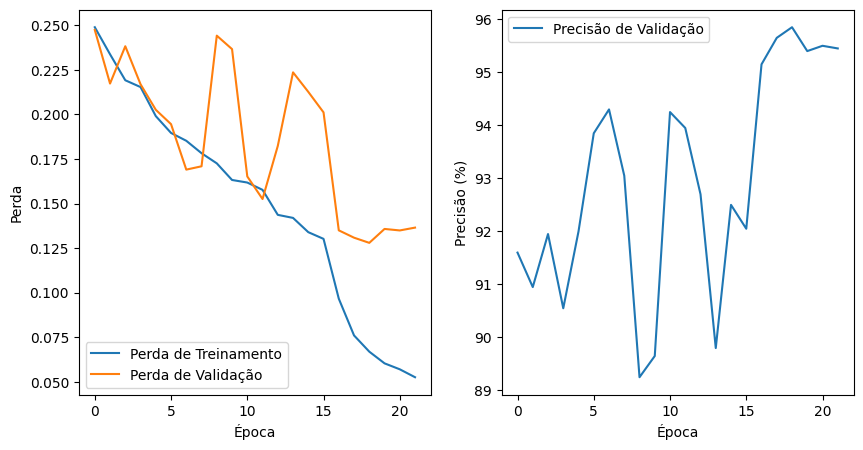

In [32]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Perda de Treinamento')
plt.plot(val_losses, label = 'Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label = 'Precisão de Validação')
plt.xlabel('Época')
plt.ylabel('Precisão (%)')
plt.legend()

plt.show()

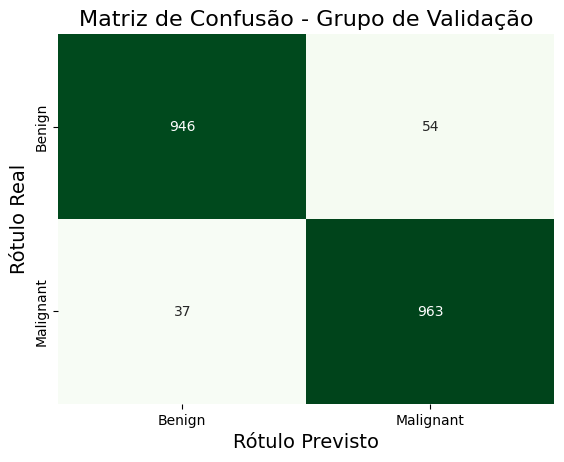

In [30]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predictions.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

matrix = confusion_matrix(all_labels, all_preds)

sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = val_data.classes, yticklabels = val_data.classes, cbar = False)
plt.title('Matriz de Confusão - Grupo de Validação', fontsize = 16)
plt.xlabel('Rótulo Previsto', fontsize = 14)
plt.ylabel('Rótulo Real', fontsize = 14)
plt.show()